# CMIP6 Hackathon: Sea ice and temperature sensitivity

October 2019  
Maddie Smith, Robin Clancy, Katie Brennan, Ed Blanchard-Wrigglesworth  


In [2]:
%matplotlib inline

import xarray as xr
import intake

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col

In [4]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year'],
      dtype='object')

In [5]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 29,
                   'values': ['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc',
                              '1pctCO2', 'abrupt-4xCO2', 'historical',
                              'piControl', 'amip', 'esm-hist', 'esm-piControl',
                              'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-hindcast-noAgung',
                              'dcppC-hindcast-noElChichon',
                              'dcppC-hindcast-noPinatubo', 'highresSST-present',
                              'control-1950', 'hist-1950', 'deforest-globe',
                              'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
                              'ssp245', 'ssp585']},
 'source_id': {'count': 48,
               'values': ['BCC-ESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-ESM2-1',
                          'UKESM1-0-LL', 'GISS-E2-1-G', 'CESM2', 'GFDL-ESM4',
                          'AWI-CM-1-1-MR', 'CAM

In [6]:
cat_siconc = col.search(experiment_id=['historical'],table_id='SImon', 
                        variable_id='siconc', grid_label='gn')

In [7]:
cat_cellarea = col.search(experiment_id=['historical'],table_id='Ofx', 
                          variable_id='areacello', grid_label='gn')
#cat_cellarea

#### Find variables models that contain certain variables

In [8]:
models_intersect = set(uni_dict['source_id']['values']) # all the models
table_id = ['SImon','Ofx']

for v,variable_id in enumerate(['siconc','areacello']):
    query = dict(experiment_id='historical', table_id=table_id[v], 
                 variable_id=variable_id, grid_label='gn')  
    cat = col.search(**query)
    models_intersect = models_intersect.intersection(
        {model_intersect for model_intersect in cat.df.source_id.unique().tolist()})

# ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# models = models - {'CESM2-WACCM', 'CESM2'}

models_intersect = list(models_intersect)
models_intersect

['MIROC-ES2L',
 'NorCPM1',
 'IPSL-CM6A-LR',
 'CanESM5',
 'EC-Earth3-Veg',
 'CESM2',
 'MIROC6',
 'EC-Earth3',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'SAM0-UNICON']

### Load data: 

In [111]:
ardset_dict = cat_cellarea.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                           cdf_kwargs={'chunks': {}, 'decode_times': False})

In [112]:
sidset_dict = cat_siconc.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': False})

In [113]:
model_name_dict = {ardset_dict[x].attrs['source_id']: x for x in ardset_dict}
si_dict = {}

for key, item in sidset_dict.items():
    model = item.attrs['source_id']
    if model in models_intersect: 
        si_dict[model] = item
        si_dict[model]['areacello'] = ardset_dict[model_name_dict[model]]['areacello']

### Calculate total Arctic sea ice area: 

In [91]:
m=models_intersect[0]
si_dict[m]['si_area'] = si_dict[m].areacello*si_dict[m].siconc/100.0
si_dict[m]['si_area'].attrs['units'] = si_dict[m].areacello.attrs['units']
si_dict[m]['si_area_tot_arc'] = si_dict[m].si_area.where(si_dict[m].latitude>0).sum(dim=['x','y'])/(1000*1000)
si_dict[m]['si_area_tot_arc'].attrs['units'] = 'km2'

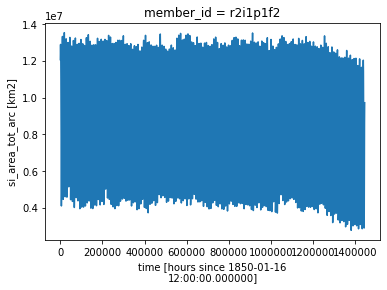

In [53]:
si_dict[m]['si_area_tot_arc'].isel(member_id=1).plot()

In [114]:
si_dict[m]['si_area_tot_arc'].time.encoding

{'units': 'hours since 1850-01-16 12:00:00.000000', 'dtype': 'float64'}

In [75]:
import numpy as np

In [77]:
attrs = {'units': 'hours since 1850-01-16 12:00:00.000000'}
ds = xr.Dataset({'time': ('time', np.arange(0,1445616,708), attrs)})

In [87]:
si_dict[m]['time_dt'] = xr.decode_cf(ds).time
si_dict[m]

<xarray.Dataset>
Dimensions:             (bnds: 2, member_id: 3, time: 1980, vertices: 4, x: 360, y: 256)
Coordinates:
  * time                (time) int64 0 708 1416 2148 ... 1444152 1444884 1445616
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * y                   (y) float64 -88.0 -85.75 -85.25 ... 148.6 150.5 152.4
  * member_id           (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    longitude           (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
    time_bnds           (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    vertices_latitude   (y, x, vertices) float32 dask.array<chunksize=(256, 360, 4), meta=np.ndarray>
    type                |S7 ...
    x_bnds              (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    vertices_longitude  (y, x, vertices) float32 dask.array<chunksize=(256, 360, 4), meta=np.ndarra

### Find overlapping runs that have both sea ice and cell area

In [103]:
sidset_keys = list(sidset_dict.keys())
ardset_keys = list(ardset_dict.keys())

#dset_keys = list(set(sidset_keys)-set(ardset_keys))

In [171]:
ardset_source = {}
for i in ardset_keys:
    ardset_source[ardset_dict[i].source_id]=i
    
sidset_source = {}
for i in sidset_keys:
    sidset_source[sidset_dict[i].source_id]=i
    
models_intersect = list(set(sidset_source.keys()).intersection(set(ardset_source.keys())))

In [196]:
siconc_ar = ardset_dict[ardset_source[models_intersect[0]]].areacello*sidset_dict[sidset_source[models_intersect[0]]].siconc
siconc_tot1 = siconc_ar[:,150:,:,:].sum(axis=1)
siconc_tot = siconc_tot1.sum(axis=1)

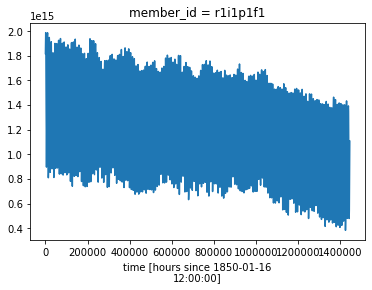

In [197]:
siconc_tot.plot()

In [185]:
siconc_ar

<xarray.DataArray (member_id: 1, j: 292, i: 362, time: 1980)>
dask.array<mul, shape=(1, 292, 362, 1980), dtype=float32, chunksize=(1, 292, 362, 120), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) object 'r1i1p1f1'
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * time       (time) int64 0 708 1416 2148 ... 1443420 1444152 1444884 1445616

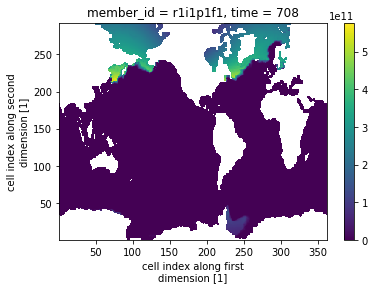

In [182]:
siconc_ar[0,:,:,1].plot()

In [178]:
sidset_dict[sidset_source[models_intersect[0]]].siconc

<xarray.DataArray 'siconc' (member_id: 1, time: 1980, j: 292, i: 362)>
dask.array<transpose, shape=(1, 1980, 292, 362), dtype=float32, chunksize=(1, 120, 292, 362), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362
  * time       (time) int64 0 708 1416 2148 ... 1443420 1444152 1444884 1445616
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * member_id  (member_id) <U8 'r1i1p1f1'
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Percentage of grid cell covered by sea ice
    long_name:      Sea-Ice Area Percentage (Ocean Grid)
    original_name:  siconc
    standard_name:  sea_ice_area_fraction
    units:          %

In [105]:
sidset_dict[dset_keys[0]].siconc[1,:,:,:]

<xarray.DataArray 'siconc' (time: 1980, y: 294, x: 362)>
dask.array<getitem, shape=(1980, 294, 362), dtype=float32, chunksize=(600, 294, 362), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) float64 15.5 45.0 74.5 ... 6.019e+04 6.022e+04 6.025e+04
    member_id  <U8 'r2i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areacello
    cell_methods:        area: mean where sea time: mean
    description:         Sea Ice Area Fraction (Ocean Grid)
    history:             none
    interval_operation:  1800 s
    interval_write:      1 month
    long_name:           Sea Ice Area Fraction (Ocean Grid)
    online_operation:    average
    standard_name:       sea_ice_area_fraction
    units:               %

In [110]:
ardset_dict[dset_keys[0]].areacello

KeyError: 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.SImon.gn'

In [112]:
ardset_dict.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.Ofx.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Ofx.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Ofx.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Ofx.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Ofx.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Ofx.gn', 'CMIP.MIROC.MIROC6.historical.Ofx.gn', 'CMIP.NCAR.CESM2.historical.Ofx.gn', 'CMIP.NCC.NorCPM1.historical.Ofx.gn', 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Ofx.gn', 'CMIP.SNU.SAM0-UNICON.historical.Ofx.gn', 'CMIP.UA.MCM-UA-1-0.historical.Ofx.gn'])

In [113]:
dset_keys

['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.SImon.gn',
 'CMIP.MIROC.MIROC6.historical.SImon.gn',
 'CMIP.MOHC.UKESM1-0-LL.historical.SImon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.SImon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.SImon.gn',
 'CMIP.MIROC.MIROC-ES2L.historical.SImon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.SImon.gn',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn',
 'CMIP.NCAR.CESM2.historical.SImon.gn',
 'CMIP.NCC.NorCPM1.historical.SImon.gn',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn',
 'CMIP.SNU.SAM0-UNICON.historical.SImon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.SImon.gn',
 'CMIP.CCCma.CanESM5.historical.SImon.gn',
 'CMIP.MOHC.HadGEM3-GC31-LL.historical.SImon.gn',
 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.SImon.gn',
 'CMIP.NUIST.NESM3.historical.SImon.gn']